In [1]:
from SimulationHelper import *
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt 
%matplotlib inline 

Hello this has loaded


In [2]:
## Multiprocessing Package - Speed up simulation
from multiprocessing import cpu_count
from dask.distributed import Client, progress
import dask
client = Client(threads_per_worker=2)
client

/home/michael/miniconda3/envs/dask/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:43523 Dashboard: http://127.0.0.1:37375/status,Cluster Workers: 8 Cores: 16 Memory: 33.60 GB


In [10]:
def run_simulation_SF_pagerank(N,n_avg,phi=0.18):
    '''
        Simulation of Scale Free Random Graphs
        Returns the average size of influenced nodes and average expected 
        time to be influenced from 
            - influential nodes
            - normal nodes
        NOTE. n_avg must be an integer.
    '''
    G = nx.barabasi_albert_graph(N,n_avg)
    set_influence(G, 0)
    set_time(G, 0)
    
    ## Retrieve influential nodes - top q% and non-influential nodes
    degree_ordered_nodes = sorted(list(G.nodes()), key=lambda x: G.degree(x), reverse=True)
    influential_nodes_5   = degree_ordered_nodes[:int(0.05*N)]
    influential_nodes_10  = degree_ordered_nodes[int(0.05*N):int(0.1*N)]
    influential_nodes_15 = degree_ordered_nodes[int(0.1*N):int(0.15*N)]
    influential_nodes_20 = degree_ordered_nodes[int(0.15*N):int(0.2*N)]
    bottom_nodes = degree_ordered_nodes[int(0.9*N):]
    normal_nodes = [x for x in G.nodes() if G.degree(x) == n_avg ]
    
    influential_S_5, influential_S_10, influential_S_15, influential_S_20 = [], [], [], []
    influential_t_5, influential_t_10, influential_t_15, influential_t_20 = [], [], [], []
    normal_S, bottom_S = [], []
    normal_t, bottom_t = [], []
    
    ## Calculate the number of influenced nodes (S) and expected time of influenced nodes
    ## for each influential node
    for node in influential_nodes_5:
        S, t = simulate_spread(G, node, phi)
        influential_S_5.append(S)
        influential_t_5.append(t)    
    for node in influential_nodes_10:
        S, t = simulate_spread(G, node, phi)
        influential_S_10.append(S)
        influential_t_10.append(t)
    for node in influential_nodes_15:
        S, t = simulate_spread(G, node, phi)
        influential_S_15.append(S)
        influential_t_15.append(t)
    for node in influential_nodes_20:
        S, t = simulate_spread(G, node, phi)
        influential_S_20.append(S)
        influential_t_20.append(t)
    for node in bottom_nodes:
        S, t = simulate_spread(G, node, phi)
        bottom_S.append(S)
        bottom_t.append(t)
    for node in normal_nodes:
        S, t = simulate_spread(G, node, phi)
        normal_S.append(S)
        normal_t.append(t)
        
    pagerank = nx.pagerank(G, weight=None)
    ordered_pr = sorted(pagerank, key=lambda x:pagerank[x], reverse=True)
    influential_nodes_5   = ordered_pr[:int(0.05*N)]
    influential_nodes_10  = ordered_pr[int(0.05*N):int(0.1*N)]
    influential_nodes_15 = ordered_pr[int(0.1*N):int(0.15*N)]
    influential_nodes_20 = ordered_pr[int(0.15*N):int(0.2*N)]
    lower = np.mean(list(pagerank.values())) - np.std(list(pagerank.values()))/2
    upper = np.mean(list(pagerank.values())) + np.std(list(pagerank.values()))/2
    normal_nodes = [x for x in pagerank if lower <= pagerank[x] <= upper]
    bottom_nodes = ordered_pr[int(0.9*N):]
    
    influential_S_5_pr, influential_S_10_pr, influential_S_15_pr, influential_S_20_pr = [], [], [], []
    influential_t_5_pr, influential_t_10_pr, influential_t_15_pr, influential_t_20_pr = [], [], [], []
    normal_S_pr, bottom_S_pr = [], []
    normal_t_pr, bottom_t_pr = [], []
    
    ## Calculate the number of influenced nodes (S) and expected time of influenced nodes
    ## for each influential node
    for node in influential_nodes_5:
        S, t = simulate_spread(G, node, phi)
        influential_S_5_pr.append(S)
        influential_t_5_pr.append(t)    
    for node in influential_nodes_10:
        S, t = simulate_spread(G, node, phi)
        influential_S_10_pr.append(S)
        influential_t_10_pr.append(t)
    for node in influential_nodes_15:
        S, t = simulate_spread(G, node, phi)
        influential_S_15_pr.append(S)
        influential_t_15_pr.append(t)
    for node in influential_nodes_20:
        S, t = simulate_spread(G, node, phi)
        influential_S_20_pr.append(S)
        influential_t_20_pr.append(t)
    for node in bottom_nodes:
        S, t = simulate_spread(G, node, phi)
        bottom_S_pr.append(S)
        bottom_t_pr.append(t)
    for node in normal_nodes:
        S, t = simulate_spread(G, node, phi)
        normal_S_pr.append(S)
        normal_t_pr.append(t)
    
    return [np.mean(influential_S_5), np.mean(influential_S_10), np.mean(influential_S_15), np.mean(influential_S_20), np.mean(influential_S_5 + influential_S_10), np.mean(influential_S_5 + influential_S_10 + influential_S_15), np.mean(influential_S_5 + influential_S_10 + influential_S_15 + influential_S_20), np.mean(normal_S), np.mean(bottom_S),
            np.mean(influential_t_5), np.mean(influential_t_10), np.mean(influential_t_15), np.mean(influential_t_20), np.mean(influential_t_5 + influential_t_10), np.mean(influential_t_5 + influential_t_10 + influential_t_15), np.mean(influential_t_5 + influential_t_10 + influential_t_15 + influential_t_20), np.mean(normal_t), np.mean(bottom_t),
            np.mean(influential_S_5_pr), np.mean(influential_S_10_pr), np.mean(influential_S_15_pr), np.mean(influential_S_20_pr), np.mean(influential_S_5_pr + influential_S_10_pr), np.mean(influential_S_5_pr + influential_S_10_pr + influential_S_15_pr), np.mean(influential_S_5_pr + influential_S_10_pr + influential_S_15_pr + influential_S_20_pr), np.mean(normal_S_pr), np.mean(bottom_S_pr),
            np.mean(influential_t_5_pr), np.mean(influential_t_10_pr), np.mean(influential_t_15_pr), np.mean(influential_t_20_pr), np.mean(influential_t_5_pr + influential_t_10_pr), np.mean(influential_t_5_pr + influential_t_10_pr + influential_t_15_pr), np.mean(influential_t_5_pr + influential_t_10_pr + influential_t_15_pr + influential_t_20_pr), np.mean(normal_t_pr), np.mean(bottom_t_pr)]


In [11]:
######################################################################
############################# Parameters #############################
######################################################################

N = 100
phi = 0.18
num_simulations = 100
max_n_avg = 36   # Must be an integer
increment = 1   # Must be an integer

n_avg = [x for x in range(1,max_n_avg+1,increment)]
n = len(n_avg)

In [12]:
%%time
pool = []
for i in tqdm(range(num_simulations)):
    for j in range(n):
        pool.append(dask.delayed(run_simulation_SF_pagerank)(N,n_avg[j], phi=phi))

results = dask.compute(pool)

100%|██████████| 100/100 [00:00<00:00, 360.68it/s]


CPU times: user 53.6 s, sys: 2.91 s, total: 56.5 s
Wall time: 5min 6s


In [13]:
tmp = np.array(results[0])
dims = (num_simulations, n)
names = ["0-5", "5-10", "10-15", "15-20", "0-10", "0-15", "0-20", "Normal", "95-100"]

s_05, s_10, s_15, s_20 =  np.reshape(tmp[:,0], dims),  np.reshape(tmp[:,1], dims),  np.reshape(tmp[:,2], dims),  np.reshape(tmp[:,3], dims)
s_010, s_015, s_020, s_n, s_95 = np.reshape(tmp[:,4], dims), np.reshape(tmp[:,5], dims),  np.reshape(tmp[:,6], dims),  np.reshape(tmp[:,7], dims),  np.reshape(tmp[:,8], dims)

t_05, t_10, t_15, t_20 = np.reshape(tmp[:,9], dims),  np.reshape(tmp[:,10], dims),  np.reshape(tmp[:,11], dims),  np.reshape(tmp[:,12], dims)
t_010, t_015, t_020, t_n, t_95 = np.reshape(tmp[:,13], dims), np.reshape(tmp[:,14], dims),  np.reshape(tmp[:,15], dims),  np.reshape(tmp[:,16], dims), np.reshape(tmp[:,17], dims)

In [14]:
s_05_pr, s_10_pr, s_15_pr, s_20_pr =  np.reshape(tmp[:,18], dims),  np.reshape(tmp[:,19], dims),  np.reshape(tmp[:,20], dims),  np.reshape(tmp[:,21], dims)
s_010_pr, s_015_pr, s_020_pr, s_n_pr, s_95_pr = np.reshape(tmp[:,22], dims), np.reshape(tmp[:,23], dims),  np.reshape(tmp[:,24], dims),  np.reshape(tmp[:,25], dims),  np.reshape(tmp[:,26], dims)

t_05_pr, t_10_pr, t_15_pr, t_20_pr = np.reshape(tmp[:,27], dims),  np.reshape(tmp[:,28], dims),  np.reshape(tmp[:,29], dims),  np.reshape(tmp[:,30], dims)
t_010_pr, t_015_pr, t_020_pr, t_n_pr, t_95_pr = np.reshape(tmp[:,31], dims), np.reshape(tmp[:,32], dims),  np.reshape(tmp[:,33], dims),  np.reshape(tmp[:,34], dims), np.reshape(tmp[:,35], dims)

In [15]:
# Number of Nodes of Network Influenced
S_05, S_10, S_15, S_20 =  np.apply_along_axis(np.mean, 0, s_05), np.apply_along_axis(np.mean, 0, s_10), np.apply_along_axis(np.mean, 0, s_15), np.apply_along_axis(np.mean, 0, s_20)
S_010, S_015, S_020, S_n, S_95 = np.apply_along_axis(np.mean, 0, s_010), np.apply_along_axis(np.mean, 0, s_015), np.apply_along_axis(np.mean, 0, s_020), np.apply_along_axis(np.mean, 0, s_n), np.apply_along_axis(np.mean, 0, s_95)

# Proportion of Network Influenced
N_05, N_10, N_15, N_20 =  [x/N for x in S_05], [x/N for x in S_10], [x/N for x in S_15], [x/N for x in S_20]
N_010, N_015, N_020, N_n, N_95 = [x/N for x in S_010], [x/N for x in S_015], [x/N for x in S_020], [x/N for x in S_n], [x/N for x in S_95]

# Averaged Time of Influenced Nodes
T_05, T_10, T_15, T_20 =  np.apply_along_axis(np.mean, 0, t_05), np.apply_along_axis(np.mean, 0, t_10), np.apply_along_axis(np.mean, 0, t_15), np.apply_along_axis(np.mean, 0, t_20)
T_010, T_015, T_020, T_n, T_95 = np.apply_along_axis(np.mean, 0, t_010), np.apply_along_axis(np.mean, 0, t_015), np.apply_along_axis(np.mean, 0, t_020), np.apply_along_axis(np.mean, 0, t_n), np.apply_along_axis(np.mean, 0, t_95)

In [16]:
# Number of Nodes of Network Influenced
S_05_pr, S_10_pr, S_15_pr, S_20_pr =  np.apply_along_axis(np.mean, 0, s_05_pr), np.apply_along_axis(np.mean, 0, s_10_pr), np.apply_along_axis(np.mean, 0, s_15_pr), np.apply_along_axis(np.mean, 0, s_20_pr)
S_010_pr, S_015_pr, S_020_pr, S_n_pr, S_95_pr = np.apply_along_axis(np.mean, 0, s_010_pr), np.apply_along_axis(np.mean, 0, s_015_pr), np.apply_along_axis(np.mean, 0, s_020_pr), np.apply_along_axis(np.mean, 0, s_n_pr), np.apply_along_axis(np.mean, 0, s_95_pr)

# Proportion of Network Influenced
N_05_pr, N_10_pr, N_15_pr, N_20_pr =  [x/N for x in S_05_pr], [x/N for x in S_10_pr], [x/N for x in S_15_pr], [x/N for x in S_20_pr]
N_010_pr, N_015_pr, N_020_pr, N_n_pr, N_95_pr = [x/N for x in S_010_pr], [x/N for x in S_015_pr], [x/N for x in S_020_pr], [x/N for x in S_n_pr], [x/N for x in S_95_pr]

# Averaged Time of Influenced Nodes
T_05_pr, T_10_pr, T_15_pr, T_20_pr =  np.apply_along_axis(np.mean, 0, t_05_pr), np.apply_along_axis(np.mean, 0, t_10_pr), np.apply_along_axis(np.mean, 0, t_15_pr), np.apply_along_axis(np.mean, 0, t_20_pr)
T_010_pr, T_015_pr, T_020_pr, T_n_pr, T_95_pr = np.apply_along_axis(np.mean, 0, t_010_pr), np.apply_along_axis(np.mean, 0, t_015_pr), np.apply_along_axis(np.mean, 0, t_020_pr), np.apply_along_axis(np.mean, 0, t_n_pr), np.apply_along_axis(np.mean, 0, t_95_pr)

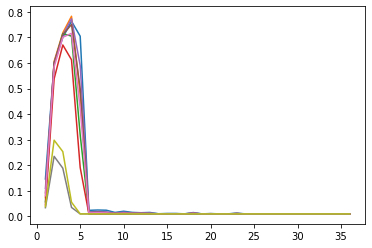

In [19]:
plt.plot(n_avg, N_05)
plt.plot(n_avg, N_10)
plt.plot(n_avg, N_15)
plt.plot(n_avg, N_20)
plt.plot(n_avg, N_010)
plt.plot(n_avg, N_015)
plt.plot(n_avg, N_020)
plt.plot(n_avg, N_n)
plt.plot(n_avg, N_95)


Text(0.5, 1.0, 'Number of Nodes Influenced')

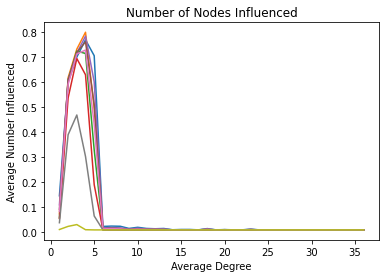

In [20]:
plt.plot(n_avg, N_05_pr)
plt.plot(n_avg, N_10_pr)
plt.plot(n_avg, N_15_pr)
plt.plot(n_avg, N_20_pr)
plt.plot(n_avg, N_010_pr)
plt.plot(n_avg, N_015_pr)
plt.plot(n_avg, N_020_pr)
plt.plot(n_avg, N_n_pr)
plt.plot(n_avg, N_95_pr)

plt.ylabel("Average Number Influenced")
plt.xlabel("Average Degree")
plt.title("Number of Nodes Influenced")
# plt.legend(names)

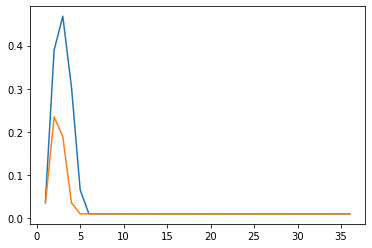

In [23]:
plt.plot(n_avg, N_n_pr)
plt.plot(n_avg, N_n)

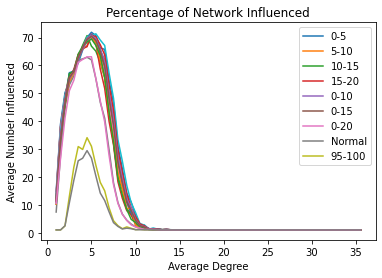

In [23]:
plt.plot(n_avg, S_05)
plt.plot(n_avg, S_10)
plt.plot(n_avg, S_15)
plt.plot(n_avg, S_20)
plt.plot(n_avg, S_010)
plt.plot(n_avg, S_015)
plt.plot(n_avg, S_020)
plt.plot(n_avg, S_n)
plt.plot(n_avg, S_95)

plt.plot(n_avg, S_05_pr)
plt.plot(n_avg, S_10_pr)
plt.plot(n_avg, S_15_pr)
plt.plot(n_avg, S_20_pr)
plt.plot(n_avg, S_010_pr)
plt.plot(n_avg, S_015_pr)
plt.plot(n_avg, S_020_pr)
plt.plot(n_avg, S_n_pr)
plt.plot(n_avg, S_95_pr)

plt.ylabel("Average Number Influenced")
plt.xlabel("Average Degree")
plt.title("Percentage of Network Influenced")
plt.legend(names)

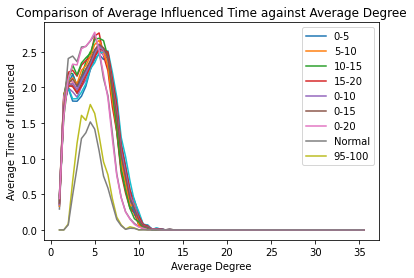

In [24]:
plt.plot(n_avg, T_05)
plt.plot(n_avg, T_10)
plt.plot(n_avg, T_15)
plt.plot(n_avg, T_20)
plt.plot(n_avg, T_010)
plt.plot(n_avg, T_015)
plt.plot(n_avg, T_020)
plt.plot(n_avg, T_n)
plt.plot(n_avg, T_95)

plt.plot(n_avg, T_05_pr)
plt.plot(n_avg, T_10_pr)
plt.plot(n_avg, T_15_pr)
plt.plot(n_avg, T_20_pr)
plt.plot(n_avg, T_010_pr)
plt.plot(n_avg, T_015_pr)
plt.plot(n_avg, T_020_pr)
plt.plot(n_avg, T_n_pr)
plt.plot(n_avg, T_95_pr)

plt.ylabel("Average Time of Influenced")
plt.xlabel("Average Degree")
plt.title("Comparison of Average Influenced Time against Average Degree")
plt.legend(names)